In [1]:
!python --version

Python 3.12.7


# Developing an Image Classifier

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications.

In this project, I train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice, you'd train this classifier, then export it for use in your application. I'll be using [**this dataset**](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below.

<img src="../assets/Flowers.png" width=500px>

The project is broken down into multiple steps:

- Load and preprocess the image dataset
- Train the image classifier on the dataset
- Use the trained classifier to predict image content

When this project is completed, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command-line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the model is, then looks up information about it.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code.

In [2]:
import os
import json
import random
from typing import List, Tuple, Dict, NamedTuple

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

os.environ["KERAS_BACKEND"] = "torch"
import keras

print("torch.__version__:", torch.__version__)
print("torch.cuda.is_available():", torch.cuda.is_available())

torch.__version__: 2.6.0+cu124
torch.cuda.is_available(): True


## Reproducibility

In [3]:
class Configs:
    
    def __init__(self) -> None:
        """
        Initialize the Configs object with default parameters for training an image classifier.
        
        Attributes:
            seed (int): Random seed for reproducibility.
            device (torch.device): Device to be used for computation (cuda or cpu).
            arch (str): Model architecture to be used.
            hidden_units (int): Number of hidden units in the model.
            batch_size (int): Batch size for training.
            learning_rate (float): Learning rate for the optimizer.
            epochs (int): Number of training epochs.
        """
        
        self.seed: int = 42
        self.device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.arch: str = "vgg16"
        self.hidden_units: int = 512
        self.batch_size: int = 64
        self.learning_rate: float = 1e-3
        self.epochs: int = 10

In [4]:
# Initialize configs
configs = Configs()

# Register "Configs" class as a safe global before loading
torch.serialization.add_safe_globals([Configs])

In [5]:
# Setting random seeds
random.seed(configs.seed)  # Python's random module
np.random.seed(configs.seed)  # NumPy random generator
torch.manual_seed(configs.seed)  # PyTorch random seed for CPU
torch.cuda.manual_seed_all(configs.seed)  # PyTorch random seed for all GPUs

# The configuration ensures that PyTorch operations are deterministic on GPUs
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Helper Functions

In [6]:
class DataLoaders(NamedTuple):
    train_loader: DataLoader
    val_loader: DataLoader
    test_loader: DataLoader
    class_to_idx: Dict[str, int]

In [7]:
def load_data(data_dir: str, batch_size: int = 64) -> DataLoaders:
    """
    Loads the dataset and returns DataLoader objects for training, validation, and testing.
    
    Args:
        data_dir (str): Path to the dataset directory, expected to contain "train/", "valid/", and "test/" subdirectories.
        batch_size (int, optional): Batch size for DataLoader. Defaults to 64.
    
    Returns:
        DataLoaders: NamedTuple containing train, validation, test loaders, and class-to-index mapping.
    """
    
    # Define transformations
    data_transforms = {
        "train": transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomRotation(30),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        
        "valid": transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        
        "test": transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }
    
    # Load datasets
    image_datasets = {
        key: datasets.ImageFolder(os.path.join(data_dir, key), transform=data_transforms[key])
        for key in ["train", "valid", "test"]
    }
    
    # Create DataLoaders
    dataloaders = {
        key: DataLoader(image_datasets[key], batch_size=batch_size, shuffle=(key == "train"))
        for key in image_datasets
    }
    
    return DataLoaders(
        train_loader=dataloaders["train"],
        val_loader=dataloaders["valid"],
        test_loader=dataloaders["test"],
        class_to_idx=image_datasets["train"].class_to_idx
    )

In [8]:
def save_checkpoint(
    model: torch.nn.Module,
    arch: str,
    hidden_units: int,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    configs: Configs,
    class_to_idx: Dict[str, int],
    filepath: str = "checkpoint.pth"
) -> None:
    """
    Save a checkpoint of a PyTorch neural network model.
    
    Args:
        model (torch.nn.Module): The neural network model to save.
        arch (str): The model architecture.
        hidden_units (int): The number of hidden units in the classifier.
        optimizer (torch.optim.Optimizer): The optimizer to save.
        epochs (int): The number of epochs the model has been trained for.
        configs (Configs): The training settings.
        class_to_idx (Dict[str, int]): A dictionary mapping class names to indices.
        filepath (str, optional): File path for saving the checkpoint. Defaults to "checkpoint.pth".
    
    Returns:
        None
    """
    
    # Move model to the CPU to ensure compatibility during loading
    model.to("cpu")
    
    # Create a dictionary to store important components of the model's state
    checkpoint = {
        "state_dict": model.state_dict(),  # Model's state dictionary
        "arch": arch,  # Model architecture
        "hidden_units": hidden_units,  # Number of hidden units in the classifier
        "optimizer_state": optimizer.state_dict(),  # Optimizer's state dictionary
        "epochs": epochs,  # Number of training epochs
        "settings": vars(configs),  # Store settings as a dictionary
        "class_to_idx": class_to_idx,  # Class-to-index mapping
    }
    
    # Save the checkpoint dictionary to the specified file path
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to {filepath}")

In [9]:
def load_checkpoint(filepath: str) -> torch.nn.Module:
    """
    Load a model checkpoint from a file.
    
    Args:
        filepath (str): The path to the checkpoint file.
    
    Returns:
        torch.nn.Module: The loaded model.
    """
    
    # Load the checkpoint dictionary from the specified file path
    checkpoint = torch.load(filepath, map_location=torch.device("cpu"), weights_only=True)
    
    # Dynamically load the correct model architecture
    model = getattr(models, checkpoint["arch"])(weights="DEFAULT")
    
    # Rebuild classifier
    model.classifier = nn.Sequential(
        nn.Linear(model.classifier[0].in_features, checkpoint["hidden_units"]),
        nn.ReLU(),
        nn.Linear(checkpoint["hidden_units"], 102),
        nn.LogSoftmax(dim=1)
    )
    
    # Load model state and class mapping
    model.load_state_dict(checkpoint["state_dict"])
    model.class_to_idx = checkpoint["class_to_idx"]
    
    print(f"Checkpoint loaded from {filepath}")
    
    return model

In [10]:
def train_loop(
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    criterion: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    epochs: int = 5,
    device: torch.device = torch.device("cpu")
) -> Dict[str, List[float]]:
    """
    Train a PyTorch model with a training loop.
    
    Args:
        train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
        model (torch.nn.Module): The PyTorch model to train.
        criterion (torch.nn.Module): The loss function to use.
        optimizer (torch.optim.Optimizer): The optimizer to use.
        epochs (int, optional): The number of epochs to train for (default is 5).
        device (torch.device, optional): The device to train on (default is torch.device("cpu")).
    
    Returns:
        Dict[str, List[float]]: A dictionary containing the training and validation
            losses and accuracies for each epoch.
    """

    # Initialize lists to store losses and accuracies
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    
    for epoch in range(epochs):

        train_loss = 0.0
        train_total, train_correct = 0, 0
        
        print(f"Epoch {epoch+1}/{epochs}")
        
        # Initialize progress bar
        n_batches = len(train_loader)
        pbar = keras.utils.Progbar(target=n_batches)
        
        # Training phase
        model.train()
        for batch, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass: Compute prediction and loss
            outputs = model(images)
            loss = criterion(outputs, labels)
            train_loss += loss.item() * images.size(0)
            
            # Calculate accuracy
            _, preds = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (preds == labels).sum().item()
            train_accuracy = 100 * (train_correct / train_total)
            
            # Backward pass: Update model weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update the progress bar with each batch
            pbar.update(batch, values=[("loss", loss.item()), ("acc", train_accuracy)])
        
        # Calculate and store average training loss and accuracy
        train_losses.append(train_loss / train_total)
        train_accuracies.append(train_accuracy)
        
        # Validation phase
        val_loss = 0.0
        val_correct, val_total = 0, 0
        
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Forward pass: Compute prediction and loss
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                
                # Calculate accuracy
                _, preds = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (preds == labels).sum().item()
            
            # Calculate and store average validation loss and accuracy
            val_loss /= val_total
            val_accuracy = 100 * (val_correct / val_total)
            
            # Final update for the progress bar with validation data
            pbar.update(n_batches, values=[("val_loss", val_loss), ("val_acc", val_accuracy)])
        
        # Calculate and store average validation loss and accuracy
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
    
    history = {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
    }
    
    return history

In [11]:
def test_loop(
    test_loader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    criterion: torch.nn.Module,
    device: torch.device = torch.device("cpu")
) -> None:
    """
    Evaluate a model on a test dataset with a test loop.
    
    Args:
        test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
        model (torch.nn.Module): The PyTorch model to evaluate.
        criterion (torch.nn.Module): The loss function to use.
        device (torch.device, optional): The device to evaluate on (default is torch.device("cpu")).
    
    Returns:
        None
    """
    
    # Initialize variables to keep track of the total loss and accuracy
    test_loss = 0.0
    test_correct, test_total = 0, 0
    
    # Create a progress bar to track the evaluation progress
    n_batches = len(test_loader)
    pbar = keras.utils.Progbar(target=n_batches)
    
    # Set the model to evaluation mode
    model.eval()
    
    # Iterate over the test data loader
    with torch.no_grad():
        for batch, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            
            # Get the predictions
            _, preds = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (preds == labels).sum().item()
            
            # Calculate the accuracy
            test_accuracy = 100 * (test_correct / test_total)
            
            # Update the progress bar
            pbar.update(batch, values=[("loss", loss.item()), ("acc", test_accuracy)])
            
            # Finish the progress bar with a final update
            if batch + 1 == n_batches:
                pbar.update(n_batches, values=None)
    
    print(f"Average loss: {test_loss / test_total:.4f}")

In [12]:
def process_image(image_path: str) -> torch.Tensor:
    """
    Process an image by resizing and cropping it to the specified size,
    then normalizing the pixel values.
    
    Args:
        image_path (str): The path to the image file.
    
    Returns:
        torch.Tensor: The processed image as a tensor.
    """
    
    image = Image.open(image_path)
    
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    return transform(image).unsqueeze(0)


def imshow(image: torch.Tensor, ax: plt.Axes = None, title: str = None) -> None:
    """
    Display an image from a PyTorch tensor.
    
    Args:
        image (torch.Tensor): The image tensor to display.
        ax (plt.Axes, optional): Matplotlib Axes to plot on. Defaults to None.
        title (str, optional): Title for the plot. Defaults to None.
    
    Returns:
        None
    """
    
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but Matplotlib assumes it is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)

In [13]:
def predict(
    image_path: str,
    model: torch.nn.Module,
    class_to_idx: Dict[str, int],
    topk: int = 5,
    device: torch.device = torch.device("cpu"),
) -> Tuple[List[float], List[str]]:
    """
    Predict the class (or classes) of an image using a trained deep learning model.
    
    Args:
        image_path (str): Path to the image file.
        model (torch.nn.Module): The trained model for prediction.
        class_to_idx (Dict[str, int]): A dictionary mapping class labels to indices.
        topk (int, optional): Number of top predictions to return. Default is 5.
        device (torch.device, optional): Device to be used for prediction (default is torch.device("cpu")).
    
    Returns:
        Tuple[List[float], List[str]]: A tuple containing a list of probabilities and a list of class labels.
    """
    
    # Set model to evaluation mode
    model.to(device)
    model.eval()
    
    # Preprocess the image
    image = process_image(image_path).to(device)
    
    # Make predictions with the model
    with torch.no_grad():
        output = model(image)
    
    # Compute the probabilities of each class
    probs = torch.nn.functional.softmax(output[0], dim=0)
    
    # Get the top k probabilities and their indices
    top_probs, top_indices = torch.topk(probs, topk)
    
    # Convert the probabilities and indices to numpy arrays
    top_probs = top_probs.cpu().numpy()
    top_indices = top_indices.cpu().numpy()
    
    # Convert the indices to class labels
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    classes = [idx_to_class[idx] for idx in top_indices]
    
    return top_probs.tolist(), classes

In [14]:
def plot_predictions(image_path: str, model: torch.nn.Module, cat_to_name: dict) -> None:
    """
    Plot the image along with the top 5 predicted class probabilities.
    
    Args:
        image_path (str): Path to the image file.
        model (torch.nn.Module): The trained model for prediction.
        cat_to_name (dict): Mapping of class indices to flower names.
    
    Returns:
        None
    """
    
    # Get predictions and corresponding class indices
    probs, classes = predict(image_path, model, class_to_idx, device=configs.device)
    flower_names = [cat_to_name.get(cls, "Unknown") for cls in classes]
    
    # Format labels with percentages: "Name (XX%)"
    formatted_labels = [f"{name} ({prob*100:.2f}%)" for name, prob in zip(flower_names, probs)]
    
    # Adjust figure size dynamically
    fig_height = max(4, 1 + 0.6 * len(formatted_labels))
    fig, (ax1, ax2) = plt.subplots(figsize=(15, fig_height), ncols=2, nrows=1)
    fig.subplots_adjust(wspace=0.7)
    
    # Display the image
    ax1.imshow(Image.open(image_path))
    ax1.axis("off")
    ax1.set_title(flower_names[0], fontsize=12, fontweight="bold", color="green")
    
    # Set bar colors ("#2ca02c" for top prediction, "#1f77b4" for others)
    colors = ["#2ca02c"] + ["#1f77b4"] * (len(probs) - 1)
    
    # Plot the probabilities
    ax2.barh(formatted_labels, probs, color=colors)
    ax2.set_xlabel("Probability", fontsize=10)
    ax2.set_title("Top Predictions", fontsize=14)
    ax2.invert_yaxis()
    
    plt.show()

## Load the Data

Here, you'll use `torchvision` to load the data ([**documentation**](https://pytorch.org/vision/stable/)). The data should be included alongside this notebook, otherwise you can download it [**here**](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz).

In [15]:
train_loader, val_loader, test_loader, class_to_idx = load_data("../data/", batch_size=configs.batch_size)

### Data Description

The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this, you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the **ImageNet** dataset where each color channel was normalized separately. For all three sets, you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images. These values will shift each color channel to be centered at 0 and range from -1 to 1.

### Explore the Dataset

In [16]:
# The shape of train, validation, and test datasets
print(
    f"Number of train dataset: {len(train_loader.dataset.imgs)}",
    f"Number of validation dataset: {len(val_loader.dataset.imgs)}",
    f"Number of test dataset: {len(test_loader.dataset.imgs)}", sep="\n"
)

Number of train dataset: 6552
Number of validation dataset: 818
Number of test dataset: 819


In [17]:
# The shape of each image as a tensor
print(next(iter(train_loader))[0][0].shape)

torch.Size([3, 224, 224])


### Label Mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat-to-name.json`. It's a JSON object which you can read in with the [**`json` module**](https://docs.python.org//library/json.html). This will give you a dictionary mapping, the integer encoded categories to the actual names of the flowers.

In [18]:
with open("../data/labels/cat-to-name.json", "r") as file:
    cat_to_name = json.load(file)

## Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pre-trained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

Things you'll need to do:

- Load a [**pre-trained network**](https://pytorch.org/vision/stable/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
- Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
- Train the classifier layers using backpropagation using the pre-trained network to get the features
- Track the loss and accuracy on the validation set to determine the best hyperparameters

When training, make sure you're updating only the weights of the feed-forward network. <font color="red"> You should be able to get the validation accuracy above 70% if you build everything right. </font> Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc.) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [19]:
# Dynamically load the model
model = getattr(models, configs.arch)(weights="DEFAULT")

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Rebuild classifier
model.classifier = nn.Sequential(
    nn.Linear(model.classifier[0].in_features, configs.hidden_units),
    nn.ReLU(),
    nn.Linear(configs.hidden_units, 102),
    nn.LogSoftmax(dim=1)
)

# Move model to the device
model.to(configs.device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [20]:
# Define the loss function
criterion = nn.NLLLoss()

# Set up the optimizer
optimizer = optim.Adam(
    model.classifier.parameters(),  # Optimize only the classifier's parameters
    lr=configs.learning_rate
)

In [21]:
history = train_loop(train_loader, val_loader, model, criterion, optimizer, configs.epochs, configs.device)

Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - loss: 2.6442 - acc: 24.6959 - val_loss: 1.0072 - val_acc: 73.1051
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - loss: 1.3197 - acc: 64.1735 - val_loss: 0.7042 - val_acc: 79.5844
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - loss: 1.1009 - acc: 69.7761 - val_loss: 0.6439 - val_acc: 80.8068
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - loss: 0.9026 - acc: 74.0742 - val_loss: 0.6255 - val_acc: 83.6186
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - loss: 0.8474 - acc: 76.0184 - val_loss: 0.5044 - val_acc: 86.6748
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - loss: 0.8208 - acc: 77.1932 - val_loss: 0.5312 - val_acc: 86.1858
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - loss: 0.7578 - acc: 77.8281 - val_loss: 0.5023 - val_acc: 85.8191
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - loss: 0.7236 - acc: 80.6951 - val_loss: 0.4930 - val_acc: 85.6968
Epoch 9/10
103/103 ━━━━━━━━━━━━━

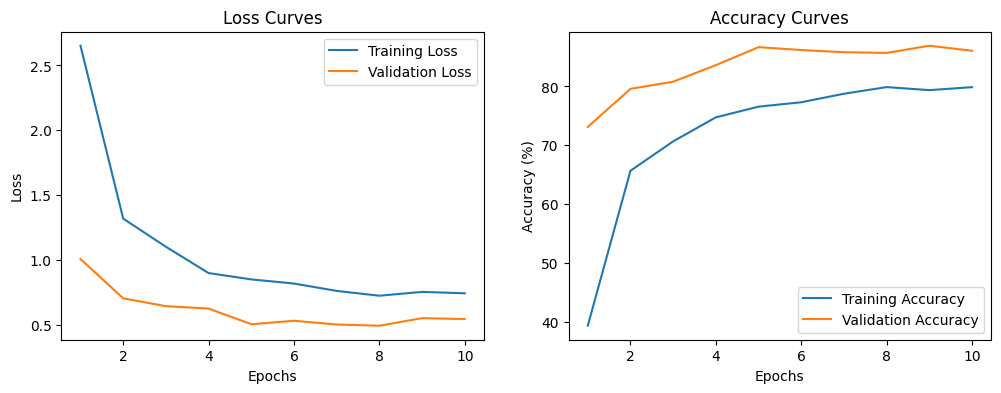

In [22]:
# Plot loss and accuracy curves for training and validation
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, configs.epochs+1), history["train_losses"], label="Training Loss")
plt.plot(range(1, configs.epochs+1), history["val_losses"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves")

plt.subplot(1, 2, 2)
plt.plot(range(1, configs.epochs+1), history["train_accuracies"], label="Training Accuracy")
plt.plot(range(1, configs.epochs+1), history["val_accuracies"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy Curves")

plt.show()

## Test the Network

It's good practice to test the trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. <font color="red"> You should be able to reach ~70% accuracy on the test set if the model has been trained well. </font>

In [23]:
test_loop(test_loader, model, criterion, configs.device)

13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - loss: 0.6484 - acc: 81.6703
Average loss: 0.6455


## Save the Checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets["train"].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```python
model.class_to_idx = image_datasets["train"].class_to_idx
```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [24]:
save_checkpoint(model, configs.arch, configs.hidden_units, optimizer, configs.epochs, configs, class_to_idx)

Checkpoint saved to checkpoint.pth


## Load the Checkpoint

At this point, it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [25]:
model = load_checkpoint("checkpoint.pth")

Checkpoint loaded from checkpoint.pth


# Inference for Classification

Now, you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top-$k$ most likely classes along with the probabilities. It should look like

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ["70", "3", "45", "62", "55"]
```

First, you'll need to handle processing the input image such that it can be used in your network.

## Image Preprocessing

You'll want to use `PIL` to load the image ([**documentation**](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training.

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [**`thumbnail`**](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.Image.thumbnail) or [**`resize`**](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.Image.resize) methods. Then, you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. you'll need to convert the values. It's easiest with a NumPy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation.

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and NumPy array. You can reorder dimensions using [**`ndarray.transpose`**](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

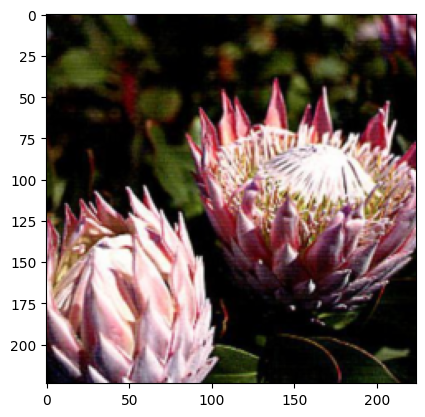

In [26]:
imshow(process_image("../assets/image-05761.jpg").squeeze(0));

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$k$) most probable classes. You'll want to calculate the class probabilities then find the $k$ largest values.

To get the top $k$ largest values in a tensor use [**`x.topk(k)`**](http://pytorch.org/docs/stable/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data. Make sure to invert the dictionary, so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ["70", "3", "45", "62", "55"]
```

In [27]:
probs, classes = predict("../assets/image-05761.jpg", model, class_to_idx, device=configs.device)

print(probs)
print(classes)

[0.8784587979316711, 0.12147895991802216, 3.274275150033645e-05, 2.0113538994337432e-05, 5.629498900816543e-06]
['13', '29', '38', '73', '77']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image.

You can convert from the class integer encoding to actual flower names with the `cat-to-name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

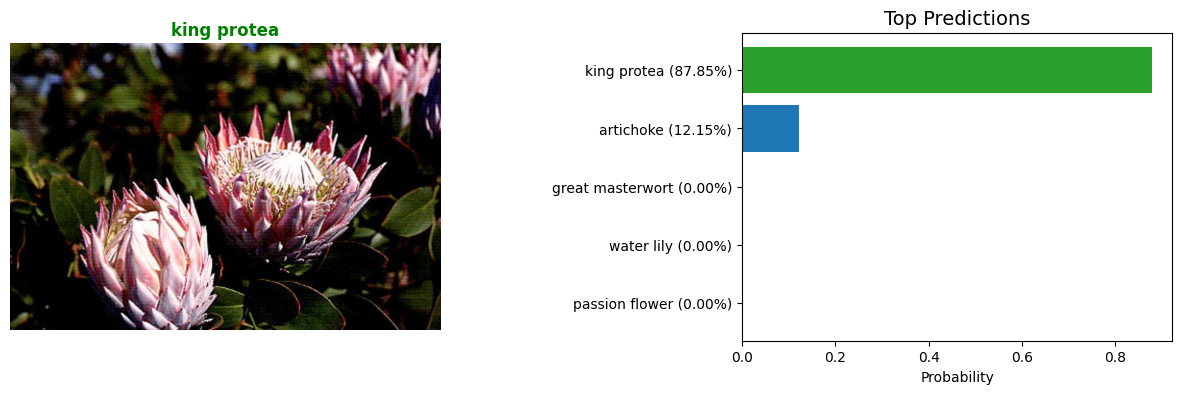

In [28]:
plot_predictions("../assets/image-05761.jpg", model, cat_to_name)